#cnn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import to_categorical
import glob
import os
from sklearn.model_selection import train_test_split

# 주파수 특성 추출 함수 (이전과 동일)
max_length = 15

def extract_features(audio_file, max_length):
    y, sr = librosa.load(audio_file, sr=None)
    if len(y) < max_length:
        y = np.pad(y, (0, max_length - len(y)), 'constant')
    elif len(y) > max_length:
        y = y[:max_length]
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features = np.concatenate((mfccs.flatten(), chroma.flatten(), spectral_contrast.flatten()))
    return features

def get_files_from_dir(path, file_format):
    # 주어진 경로와 그 하위 경로에서 특정 형식의 파일들을 찾습니다.
    return glob.glob(os.path.join(path, f'**/*.{file_format}'), recursive=True)



In [ ]:
# AI 음성파일들
ai_subfolders = ['sm', 'sy', 'mh']
ai_audio_files = []
for folder in ai_subfolders:
    ai_audio_files.extend(get_files_from_dir(f'/content/drive/MyDrive/PBL/ai_voice/ai/{folder}', 'mp3'))

# 사람 음성파일들
human_subfolders = ['cy', 'sy', 'hs']
human_audio_files = []
for folder in human_subfolders:
    human_audio_files.extend(get_files_from_dir(f'/content/drive/MyDrive/PBL/ai_voice/human/{folder}', 'mp3'))

ai_features = [extract_features(audio_file,max_length) for audio_file in ai_audio_files]
human_features = [extract_features(audio_file,max_length) for audio_file in human_audio_files]

ai_labels = np.zeros(len(ai_features))
human_labels = np.ones(len(human_features))

X_train_test= np.vstack(ai_features + human_features)
y_train_test= np.concatenate((ai_labels, human_labels))

print("Shape of X_train_test:", X_train_test.shape)
print("Shape of y_train_test:", y_train_test.shape)

# 학습 데이터와 테스트 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(X_train_test,y_train_test,test_size=0.2)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=15
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Shape of X_train_test: (204, 32)
Shape of y_train_test: (204,)


In [ ]:
# 모델 정의
model=Sequential()
model.add(Conv1D(filters=64,kernel_size=5,strides=1,padding="same",activation="relu",input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))
model.add(Conv1D(filters=32,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=len(set(np.concatenate((ai_labels, human_labels)))),activation="softmax"))


In [ ]:

# 모델 컴파일 및 학습
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = to_categorical(y_train)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = to_categorical(y_test)

history=model.fit(X_train,y_train,batch_size=16,epochs=30,validation_data=(X_test,y_test))



Epoch 1/30
11/11 [==============================] - 1s 23ms/step - loss: 13.4596 - accuracy: 0.5583 - val_loss: 6.0477e-07 - val_accuracy: 1.0000
Epoch 2/30
11/11 [==============================] - 0s 5ms/step - loss: 4.3602 - accuracy: 0.7853 - val_loss: 2.4714e-07 - val_accuracy: 1.0000
Epoch 3/30
11/11 [==============================] - 0s 5ms/step - loss: 1.4703 - accuracy: 0.8957 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/30
11/11 [==============================] - 0s 7ms/step - loss: 0.6547 - accuracy: 0.9632 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/30
11/11 [==============================] - 0s 7ms/step - loss: 0.5622 - accuracy: 0.9509 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/30
11/11 [==============================] - 0s 7ms/step - loss: 0.3105 - accuracy: 0.9755 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/30
11/11 [==============================] - 0s 7ms/step - loss: 0.1423 - accuracy: 0.9877 - val_loss: 0.0000e+00 - val_accurac

In [ ]:
# 예측 및 결과 출력
test_audio_file = "/content/drive/MyDrive/PBL/ai_voice/ai/ai_phone_call_noise.mp3"
test_features = extract_features(test_audio_file, max_length)
test_features = test_features.reshape(1, test_features.shape[0], 1)
prediction = model.predict(test_features)
predicted_class = np.argmax(prediction)  # 가장 높은 확률을 가진 클래스 선택

confidence = prediction[0][predicted_class] * 100  # 선택된 클래스의 확률

if predicted_class == 0:
    print(f"테스트 음성은 AI 음성입니다. (확신도: {confidence:.2f}%)")
else:
    print(f"테스트 음성은 인간 음성입니다. (확신도: {confidence:.2f}%)")


1/1 [==============================] - 0s 21ms/step
테스트 음성은 인간 음성입니다. (확신도: 100.00%)


In [ ]:
# 예측 및 결과 출력
test_audio_file = "/content/drive/MyDrive/PBL/ai_voice/ai/vocals_10sec.mp3"
test_features = extract_features(test_audio_file, max_length)
test_features = test_features.reshape(1, test_features.shape[0], 1)
prediction = model.predict(test_features)
predicted_class = np.argmax(prediction)  # 가장 높은 확률을 가진 클래스 선택

confidence = prediction[0][predicted_class] * 100  # 선택된 클래스의 확률

if predicted_class == 0:
    print(f"테스트 음성은 AI 음성입니다. (확신도: {confidence:.2f}%)")
else:
    print(f"테스트 음성은 인간 음성입니다. (확신도: {confidence:.2f}%)")


1/1 [==============================] - 0s 20ms/step
테스트 음성은 AI 음성입니다. (확신도: 100.00%)


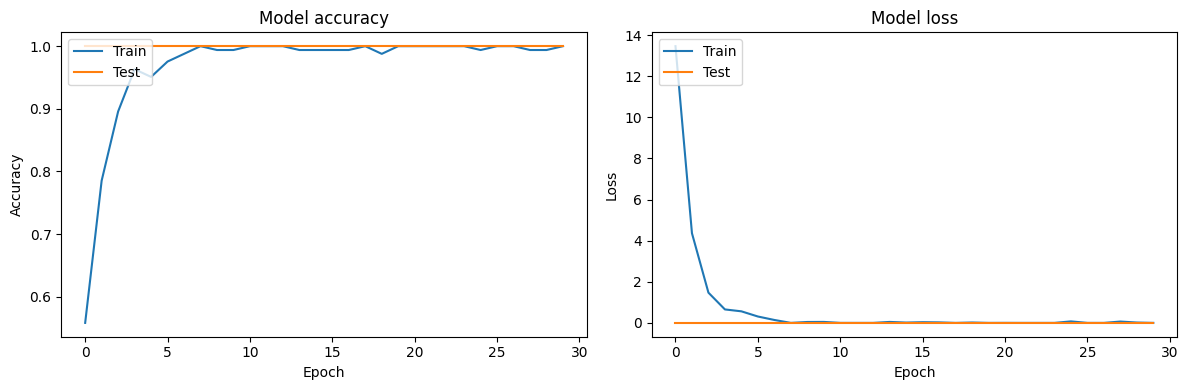

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show the plot
plt.tight_layout()


#추가적으로 필요한 코드들

In [ ]:
import os
from pydub import AudioSegment

# 경로 설정
folder_path = "/content/drive/MyDrive/PBL/ai_voice/"

# 모든 음성 파일의 길이 저장할 리스트 생성
lengths = []

# 주어진 경로와 그 하위 모든 디렉토리 탐색
for root, dirs, files in os.walk(folder_path):
    for file in files:
        # 만약 확장자가 .mp3 또는 .wav인 파일일 경우
        if file.endswith('.mp3') or file.endswith('.wav'):
            # 음성 파일 로드
            audio_file_path = os.path.join(root, file)
            audio = AudioSegment.from_file(audio_file_path)

            # 음성 파일의 길이 (밀리초 단위) 저장
            lengths.append(len(audio))

# 최소길이와 최대길이 출력 (밀리초 단위를 초단위로 변환하기 위해 1000으로 나눔)
print(f"최소길이: {min(lengths)/1000} 초")
print(f"최대길이: {max(lengths)/1000} 초")


In [ ]:
!pip install pydub
import os
import librosa
import numpy as np
import soundfile as sf

# silence trimming function
def trim_silence(audio_path, top_db=20):
    # Load audio file
    y, sr = librosa.load(audio_path)

    # Trim the beginning and ending silence below a threshold
    yt, index = librosa.effects.trim(y, top_db=top_db)

    return yt, sr

# process function for each folder and save in new directories
def process_and_save(base_dir, new_base_dir, folders):
    if not os.path.exists(new_base_dir):
        os.makedirs(new_base_dir)

    for folder in folders:
        old_folder_path = os.path.join(base_dir, folder)
        new_folder_path = os.path.join(new_base_dir, folder)

        if not os.path.exists(new_folder_path):
            os.makedirs(new_folder_path)

        for filename in os.listdir(old_folder_path):
            if filename.endswith(".mp3"):
                old_file_path = os.path.join(old_folder_path, filename)
                new_file_path = os.path.join(new_folder_path,
                                             filename.replace('.mp3', '.wav'))

                audio_data,sr = trim_silence(old_file_path)
                sf.write(new_file_path,audio_data,sr)


# define directories and folders
ai_dirs = '/content/drive/MyDrive/PBL/ai_voice/ai'
human_dirs= '/content/drive/MyDrive/PBL/ai_voice/human'

new_ai_dirs= '/content/drive/MyDrive/PBL/ai_voice/ai_padding'
new_human_dirs= '/content/drive/MyDrive/PBL/ai_voice/human_padding'

folders_ai=['sm', 'sy', 'mh']
folders_human=['cy', 'sy', 'hs']

# Process ai dirs
process_and_save(ai_dirs,new_ai_dirs,folders_ai )

# Process human dirs
process_and_save(human_dirs,new_human_dirs,folders_human )


In [ ]:
!pip install librosa

import librosa
import librosa.display

import IPython.display as ipd

import numpy as np
import matplotlib.pyplot as plt

voice='/content/drive/MyDrive/PBL/ai_voice/human_padding/sy/20230911171911.wav'


y, sr = librosa.load(voice, sr=16000)

print('sr:', sr, ', audio shape:', y.shape)
print('length:', y.shape[0]/float(sr), 'secs')

#ai_voice

plt.figure(figsize = (10,5))
librosa.display.waveshow(y, sr=sr)
plt.ylabel("Amplitude")
plt.show()